Given:
- sparseframe pixels file (s, f, omega, intensity)
- parameters file
- spatial distortion images (sraw -> sc, fraw -> fc)
- ubi file for list of grains
    
ForEach pixel:
- assign it to one or more grains with h,k,l,sign(eta) label
- best grain + hklid
- second best grain + hklid -> to determine whether this is an overlap problem / twin

In [1]:
import sys, time
start = time.time()
import numpy as np, pylab as pl
from ImageD11 import transform, parameters, cImageD11, indexing, columnfile, sym_u, blobcorrector, grain, sparseframe
import fabio, h5py


PLOT = True
%matplotlib inline

In [2]:
parfile = "CeO2.par"
sparsefile = "silicon_fullscan_strong_sparse.h5"

In [3]:
%%time 
pars = parameters.read_par_file( parfile ).parameters
pars['dxfile'] = "/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dx.edf"
pars['dyfile'] = "/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dy.edf"
tabl = transform.PixelLUT( pars )
print(tabl)

PixelLUT( { 'y_center' : 1052.8110762921149,
'z_center' : 1126.3638434538875,
'y_size' : 75,
'z_size' : 75,
'distance' : 199745.7890721506,
'wavelength' : 0.281784,
'omegasign' : 1.0,
'tilt_x' : 0.002447409671123302,
'tilt_y' : 0.000775118251263542,
'tilt_z' : 0.0012905631099530846,
'o11' : 1,
'o12' : 0,
'o21' : 0,
'o22' : -1,
'wedge' : 0.0,
'chi' : 0.0,
'dxfile' : '/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dx.edf',
'dyfile' : '/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dy.edf',
'shape' : (2162, 2068), } )
CPU times: user 759 ms, sys: 1.2 s, total: 1.96 s
Wall time: 1.48 s


In [4]:
si, fi = int( tabl.pars['z_center'] ), int( tabl.pars['y_center'])
ref = tabl.k[:,si,fi]
sub_pixel_factor = 0
nfac = 0
for i in range(-1,2):
    for j in range(-1,2):
        dk = (tabl.k[:,si+i,fi+j]-ref)
        if i!=0 or j!=0:
            # actual distance will be from the center to 1/4 and 3/4 points
            sf = np.dot(dk,dk)/(i*i+j*j)/16
            sub_pixel_factor += sf
            nfac += 1

sub_pixel_factor /= 8
print(sub_pixel_factor)   # FIXME : do the integral!

1.1097230476177632e-07


In [5]:
def MB(num):
    return "%.3f MB"%(num / (1024*1024) )

with h5py.File(sparsefile ,"r") as hin:
    for scan in hin:
        s = hin[scan]
        print(scan,list(s))
        print(dict(s.attrs))
        for column in list(s['measurement']):
            print(column, s['measurement'][column].shape)
        nnz = s['nnz'][:]
        ipt = np.cumsum(nnz)
        print("pixels",ipt[-1],"per frame avg:", ipt[-1]/len(nnz))
        nbytes = 0
        for name in 'row','col','frame','intensity','measurement/rot_center':
            a = s[name]
            b = a.dtype.itemsize * a.size
            print(name, a.shape, a.dtype, a.size, MB(b))
            nbytes += b
        print(MB(nbytes))

1.1 ['col', 'frame', 'instrument', 'intensity', 'measurement', 'nnz', 'row']
{'itype': 'uint16', 'nframes': 180500, 'shape0': 2162, 'shape1': 2068}
rot_center (180500,)
pixels 1386348 per frame avg: 7.680598337950139
row (1386348,) uint16 1386348 2.644 MB
col (1386348,) uint16 1386348 2.644 MB
frame (1386348,) uint32 1386348 5.288 MB
intensity (1386348,) uint16 1386348 2.644 MB
measurement/rot_center (180500,) float64 180500 1.377 MB
14.598 MB


In [6]:
s = sparseframe.SparseScan( sparsefile, "1.1" )

In [7]:
s.motors

{'omega': array([1.0100000e-03, 3.0700000e-03, 5.1500000e-03, ..., 3.6097963e+02,
        3.6098161e+02, 3.6098359e+02])}

85957
CPU times: user 842 ms, sys: 0 ns, total: 842 ms
Wall time: 841 ms


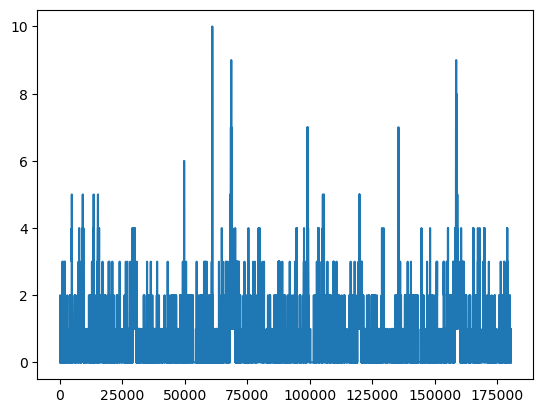

In [8]:
%%time
s.cplabel()
if PLOT:
    pl.figure()
    pl.plot(s.nlabels)
print(s.total_labels)

In [9]:
%time
c = columnfile.colfile_from_dict( s.moments() )

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs


In [10]:
sc, fc = tabl.spatial( c.s_raw, c.f_raw )
c.addcolumn( sc, 'sc')
c.addcolumn( fc, 'fc')
c.parameters.loadparameters(parfile)
c.updateGeometry()

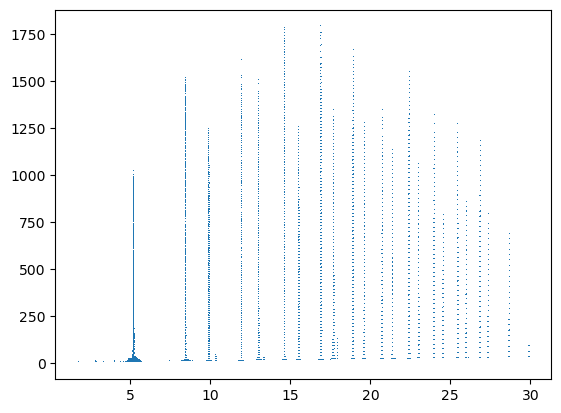

In [11]:
if PLOT:
    pl.figure()
    pl.plot(c.tth, c.Number_of_pixels * c.tth,",")

In [12]:
mask = (c.tth * c.Number_of_pixels) > 1000
c.filter(mask)

In [13]:
a0 = 5.43094
[c.parameters.set("cell__%s"%(abc), a0) for abc in 'abc']
i = indexing.indexer_from_colfile( c )
i.assigntorings()

info: gv: [[-0.09219293 -0.59355797 -0.53267211]
 [-0.09220581 -0.59352173 -0.53265925]
 [-0.09221435 -0.59346271 -0.53264467]
 ...
 [-0.09226407 -0.59329174 -0.53257455]
 [-0.09226985 -0.5932261  -0.53254685]
 [-0.09227603 -0.59317154 -0.53251063]] (3980, 3) float64
info: Assign to rings, maximum d-spacing considered: 1.647130
info: Ring assignment array shape (3980,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 27  ( -8, -4,  0)   24     16       0       16     0     31  26.83
info: Ring 26  ( -6, -6, -2)   24      0       0        0     0     31  26.14
info: Ring 25  ( -7, -5, -1)   56      0       0        0     0     72  25.97
info: Ring 24  ( -6, -6,  0)   36     82       0       82     1     46  25.43
info: Ring 23  ( -6, -4, -4)   48      0       0        0     0     62  24.71
info: Ring 22  ( -7, -3, -3)   24      0       0        0     0     31  24.52
info: Ring 21  ( -8,  0,  0)    6     59       0       59     7      7  23.

info: hkls of rings being used for indexing
info: Ring 1: [(-8, 0, 0), (0, -8, 0), (0, 0, -8), (0, 0, 8), (0, 8, 0), (8, 0, 0)]
info: Ring 2: [(-8, 0, 0), (0, -8, 0), (0, 0, -8), (0, 0, 8), (0, 8, 0), (8, 0, 0)]
info: Possible angles and cosines between peaks in rings:
info: 90.000000 0.000000
info: Number of peaks in ring 1: 59
info: Number of peaks in ring 2: 59
info: Minimum number of peaks to identify a grain 1000
info: Number of trial orientations generated 59
info: Time taken 0.000217 /s
info: Scoring 59 potential orientations
info: new grain 3980 pks, i 3826 j 3284 UBI  -3.390993 2.519056 3.411685 0.177557 4.448349 -3.109227 -4.236830 -1.830363 -2.861167
info: Number of orientations with more than 1000 peaks is 1
info: Time taken 0.012/s
info: UBI for best fitting
[[-3.39099327  2.51905608  3.41168503]
 [ 0.17755698  4.44834902 -3.10922664]
 [-4.23682964 -1.83036327 -2.86116678]]
info: Unit cell: (5.429923906088965, 5.430158912151468, 5.430214585958626, 89.99680817009921, 90.009

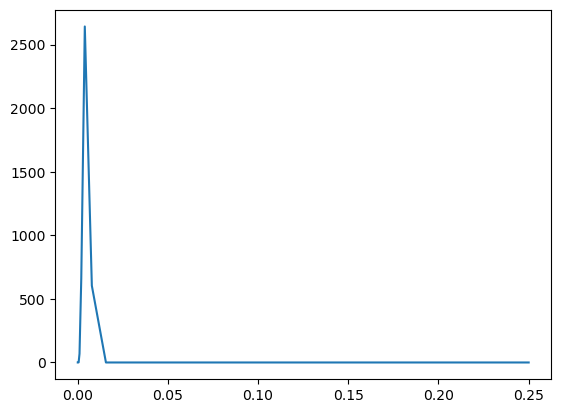

In [14]:
i.minpks = 1000
i.hkl_tol = 0.1
i.ring_1 = i.ring_2 = 21
i.find()
i.scorethem()
print("Got",len(i.ubis),"grains")
i.histogram_drlv_fit()
if PLOT:
    pl.figure()
    for j in range(len(i.ubis)):
        pl.plot(i.bins[1:], i.histogram[j],"-")

In [15]:
cubic = sym_u.cubic()
ubis = i.ubis = [ sym_u.find_uniq_u( ubi, cubic ) for ubi in i.ubis]
ubis[0]

array([[ 4.23682964,  1.83036327,  2.86116678],
       [ 0.17755698,  4.44834902, -3.10922664],
       [-3.39099327,  2.51905608,  3.41168503]])

In [16]:
indexing.ubitocellpars(ubis[0])

(5.430214585958626,
 5.430158912151468,
 5.429923906088965,
 90.00807561734301,
 89.99003768999255,
 90.00319182990079)

In [17]:
tabl.k.shape, len(s.row)

((3, 2162, 2068), 1386348)

In [18]:
s.shape, s.row.shape, s.motors['omega'].shape, s.ipt.shape

((180500, 2162, 2068), (1386348,), (180500,), (180501,))

In [19]:
%%time
pixel_omega = np.zeros( s.row.shape, float )
for frm in range(s.shape[0]):
    pixel_omega[ s.ipt[frm] : s.ipt[frm+1] ] = s.motors['omega'][frm]

CPU times: user 145 ms, sys: 0 ns, total: 145 ms
Wall time: 144 ms


In [20]:
%%time
gve = transform.compute_g_from_k( tabl.k[:, s.row, s.col] , pixel_omega )
gve.shape

CPU times: user 77 ms, sys: 30.4 ms, total: 107 ms
Wall time: 106 ms


(3, 1386348)

In [21]:
%time 
ga = np.empty( s.col.shape )
ga.fill(-1)
ge = np.ones( s.col.shape )
for k, ubi in enumerate( i.ubis ):
    hkl = np.dot( ubi, gve )
    print(hkl.shape)
    gcalc = np.dot( np.linalg.inv(ubi), np.round(hkl) )
    gerr = gcalc - gve
    modge = (gerr**2).sum(axis=0)
    best = (modge < ge)
    ga[best] = k

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 5.25 µs
(3, 1386348)


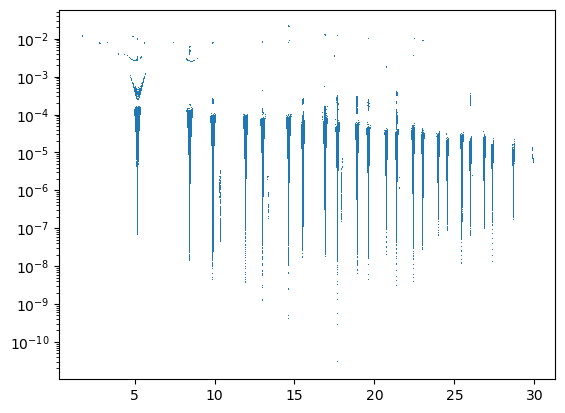

In [22]:
ptth = tabl.tth[ s.row, s.col ]
peta = tabl.eta[ s.row, s.col ]
if PLOT:
    pl.figure()
    pl.plot( ptth, modge, "," )
    pl.semilogy()

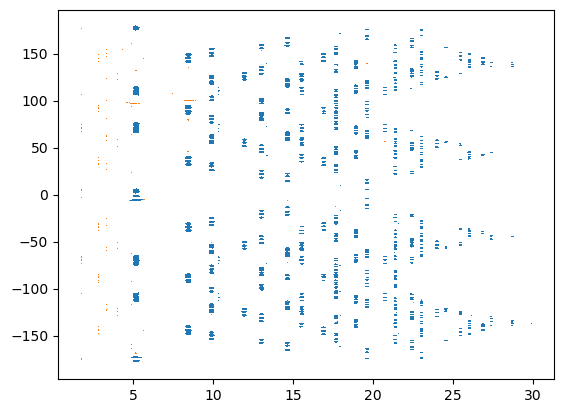

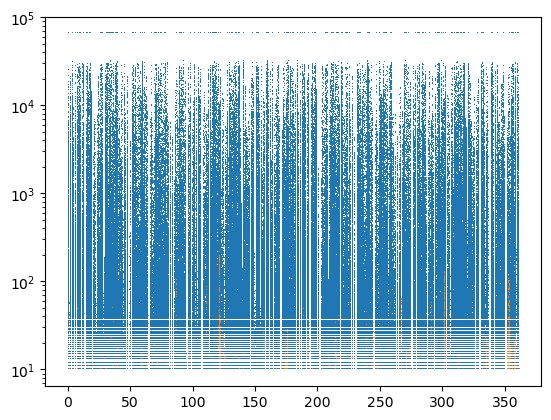

In [23]:
m = modge<0.001
if PLOT:
    pl.figure()
    pl.plot( ptth[  m ], peta[ m], ",")
    pl.plot( ptth[ ~m ], peta[~m], ",")
    pl.figure()
    pl.plot( pixel_omega[m], s.intensity[m], ',')
    pl.plot( pixel_omega[~m], s.intensity[~m], ',')
    pl.semilogy()

Here, we can now have all the pixels assigned to their grain and hkls 

... to do next:
- build a refinement engine using intensity weighting
- deal with saturated peaks

In [24]:
print("Total time",time.time()-start)

Total time 6.923663139343262


In [25]:
ubi = i.ubis[0]
print(gve.shape)
h,k,l = np.round( np.dot( ubi, gve ) ).astype(int)
gcalc = np.dot( np.linalg.inv(ubi), (h,k,l) )
mgerr  = ((gve - gcalc)**2).sum(axis=0)
m = mgerr < 0.001
se = np.sign(peta).astype(int)

(3, 1386348)


In [26]:
%%time
sortkeys = ( h,k,l,se )
order = np.lexsort( sortkeys )
print(order.shape)

(1386348,)
CPU times: user 104 ms, sys: 70.5 ms, total: 175 ms
Wall time: 98.6 ms


In [27]:
%%time

# indexing from 0 -> h.max() ...  -h.min()->end
nh = h.max() - h.min() + 1
nk = k.max() - k.min() + 1
nl = l.max() - l.min() + 1
ne = 3
gvar = np.zeros( (3, 3, nh, nk, nl, ne), float )
gavg = np.zeros( (3, nh, nk, nl, ne), float )
f = np.zeros( (nh, nk, nl, ne), float )
e = np.zeros( (9,) ,dtype=float).reshape(3,3)
# this does not accumulate !
# f[h[m],k[m],l[m],se[m]] += s.intensity[m]
# gavg[:, h[m], k[m], l[m], se[m]] += gve[:,m]*s.intensity[m]
import numba
@numba.njit
def incr( m, h, k, l, se, gve, sig, gavg, f, gvar, e  ):
    # Compute the mean g-vectors in mask:
    for p in range(len(m)):
        if m[p]:
            gavg[:, h[p],k[p],l[p],se[p]] += sig[p] * gve[:,p]
            f[ h[p],k[p],l[p],se[p]] += sig[p]
    # Get the mean
    for i in range(f.size):
        v = f.flat[i] 
        if v > 0:
            gavg[0].flat[i] /= v
            gavg[1].flat[i] /= v
            gavg[2].flat[i] /= v
    # Now get the variances:
    #       subpixel_factor = 1.7e-6     # From above. This is the in-plane error
    #                                    # not rotational, which depends on omega step.
    #                 FIXME - not entirely correct yet. Problem goes back a long time.
    for p in range(len(m)):
        if m[p]:
            dg = gve[:,p] - gavg[:,h[p],k[p],l[p],se[p]]
            # this loop is np.outer( dg, dg )
            for i in range(3):
                for j in range(3):
                    gvar[i, j, h[p],k[p],l[p],se[p]]  += (dg[i]*dg[j])*sig[p]
            for i in range(3):
                gvar[ i, i, h[p], k[p], l[p], se[p]]  += sub_pixel_factor*sig[p]
            # We are missing a pixel size contribution here. The pixel 
            # is not a point in space. This wants to sum up over, for 
            # example 2 subpixels as (sig/2 times:)
            #    outer( dg + p, dg + p ) + ...->    dg(x)dg + 2 dg(x)p + p(x)p
            #    outer( dg - p, dg - p ) + ...->    dg(x)dg - 2 dx(x)p + p(x)p
                    
    for p in range(f.size):
        v = f.flat[p]
        if v > 0:
            for i in range(3):
                for j in range(3):
                    e[i,j] = gvar[i,j].flat[p] / v
            d = np.linalg.det(e)
            if d <= 0:
                print('error')
                print(e, p, v, d)
                return None
            ie = np.linalg.inv(e)
            if ie[0,0] < 0:
                print('error -ve')
                print( e, p, v, d )
                print(ie)
                print( 'y',gvar[:,:].flat[p] )
                return None
            for i in range(3):
                for j in range(3):
                     gvar[i,j].flat[p] = ie[i,j]
            

incr( m, h, k, l, se, gve, s.intensity, gavg, f, gvar, e )

CPU times: user 2.76 s, sys: 77.2 ms, total: 2.84 s
Wall time: 3.15 s


In [28]:
%%time
gvar = np.zeros( (3, 3, nh, nk, nl, ne), float )
gavg = np.zeros( (3, nh, nk, nl, ne), float )
f = np.zeros( (nh, nk, nl, ne), float )
incr( m, h, k, l, se, gve, s.intensity, gavg, f, gvar, e )

CPU times: user 305 ms, sys: 10 µs, total: 305 ms
Wall time: 302 ms


In [29]:
# option 1: take the average of the observed pixels
np.dot(ubi, gavg[:,1,1,1,1]),np.dot(ubi, gavg[:,3,1,1,-1]),
# option 2: take the computed gcalc position
gcalc = np.dot( np.linalg.inv( ubi ), np.round( np.dot( ubi, gve ) ) )
gerr = gcalc - gve

In [30]:
# check
gvar[:,:,3,1,1,1], gavg[:,3,1,1,1], f[3,1,1,1]

(array([[ 2544323.6662985 , -1366445.53506615,   -68710.50007142],
        [-1366445.53506615,  2267881.27399326,    81535.01403616],
        [  -68710.50007142,    81535.01403616,   985649.0529475 ]]),
 array([0.32242676, 0.4226728 , 0.30082042]),
 3218220.0)

In [31]:
# example 
dg = np.dot( np.linalg.inv(ubi), (3,1,1) ) - gavg[:,3,1,1,1]
np.dot(dg, np.dot( gvar[:,:,3,1,1,1], dg ))

0.41246806399426805

In [32]:
# example
dg = np.dot( np.linalg.inv(ubi), (5,3,3) ) - gavg[:,5,3,3,1]
print(dg,'\n', gvar[:,:,5,3,3,1], f[5,3,3,1])
np.dot(dg, np.dot( gvar[:,:,5,3,3,1], dg ))

[-4.74061255e-04  1.21921328e-04  1.44423837e-05] 
 [[ 5867692.23582569 -2270150.02409414  -650214.73170314]
 [-2270150.02409414  1974761.09493604    73067.29469418]
 [ -650214.73170314    73067.29469418  1348995.90397403]] 289592.0


1.6198880818101624

In [33]:
%%time
gouter = np.einsum( 'ik,jk->ijk', gerr, gerr )
assert gouter.shape == (3,3,gerr.shape[1])
assert np.allclose( np.outer( gerr[:,3], gerr[:,3] ), gouter[:,:,3] )

CPU times: user 34.9 ms, sys: 50.9 ms, total: 85.8 ms
Wall time: 49.3 ms


795
[ 0.143668    0.00599704 -0.11500917  0.0620745   0.15086697  0.08542254
  0.09695085 -0.10536001  0.11561242]
[9.92401325e-06 6.89078235e-06 9.13867141e-06 7.16004968e-06
 1.01916045e-05 7.91843667e-06 1.12661532e-05 1.12959971e-05
 1.12832120e-05]


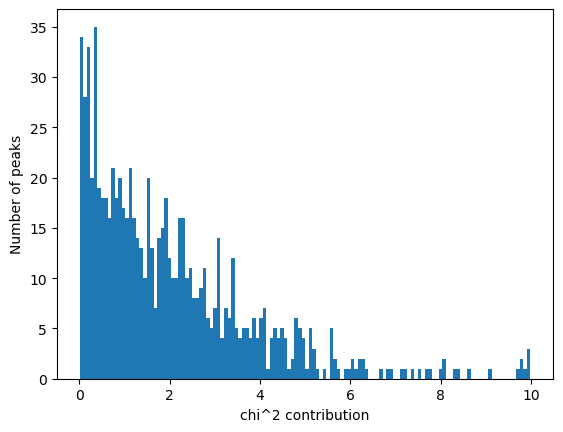

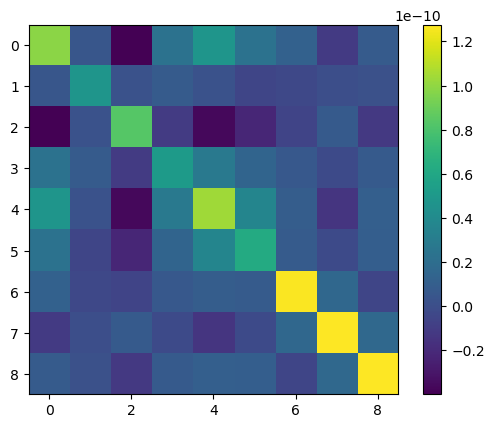

In [34]:
# MAM'x = MAd
#  ... A  == gvar               3x3
#  ... d  == gobs - gcalc       3
#  ... M' == dg/dvariable       9x3
#  ... x  == variables          9
#
#  9x3.3x3.3x9.9 = 9x3.3x3.3


M = np.zeros( (9,3), float )
LSM = np.zeros( (9,9), float )
RHS = np.zeros( (9,), float)

def dg_dUB( M, h, k, l ):
    """ 
    dg_dUB :
      gx = UB_00.h UB_01.h UB_02.l
      gy = UB_10.h UB_11.h UB_12.l
      gz = UB_20.h UB_21.h UB_22.l
    M is 9x3 :
      UB, g
    """
    #          x y z
    M[:,:] = ((h,0,0),
              (k,0,0),
              (l,0,0),
              (0,h,0),
              (0,k,0),
              (0,l,0),
              (0,0,h),
              (0,0,k),
              (0,0,l) )
    return M
        
ub = np.zeros((3,3), float) # Linear problem. hkl already assigned
ub = np.linalg.inv( ubis[0]) # not for error estimation - need chi^2
npk = 0
g_to_fit = []
h_to_fit = []
XI2 = []
fsum = f.sum()
for ih in  range(h.min(), h.max()+1):
    for ik in  range(k.min(), k.max()+1):
        for il in  range(l.min(), l.max()+1):
            for sign_eta in (-1,1):
                # total intensity for this peak
                signal = f[ih,ik,il,sign_eta]/fsum
                if signal == 0:
                    continue
                npk += 1
                # This matrix already carries an intensity weighting factor
                A = gvar[:,:,ih,ik,il,sign_eta]   # 3x3
                # A = np.eye(3)
                gobs = gavg[:,ih,ik,il,sign_eta]  # 3
                gcalc = np.dot( ub, (ih,ik,il) )  # 3
                ge = gobs - gcalc
                # Contribution to fit
                scor = np.dot(ge, np.dot( A, ge ) ) 
                assert scor >= 0
                cut = 2 * 10
                weight = cut*cut/(cut*cut+scor*scor) # weight goes down as scor goes up
                XI2.append( scor*weight )
                # For later debugging
                if 1:
                    g_to_fit.append( gobs )
                    h_to_fit.append( (ih,ik,il) )
                M   = dg_dUB( M, ih, ik, il )
                MA   = np.dot( M , A )
                LSM += np.dot( MA,  M.T ) * weight
                RHS += np.dot( MA, ge )   * weight
                # import pdb;pdb.set_trace()
#LSM *= npk/XI2
#RHS *= npk/XI2
iMAT = np.linalg.inv( LSM )
ecorfac = np.sum( XI2 ) / (npk - len(RHS) )   # potentially a factor of 2 here in scipy?
pCOV = iMAT * ecorfac
shifts = np.dot( iMAT, RHS) + ub.ravel()
print(npk)
print(shifts)
print(np.sqrt(np.diag(pCOV)))
pl.figure()
pl.hist( XI2, bins=128 )
pl.ylabel("Number of peaks")
pl.xlabel("chi^2 contribution")
pl.figure()
pl.imshow(pCOV)
pl.colorbar()

In [35]:
ubfit = shifts.reshape(3,3)
ubi_fit = np.linalg.inv( ubfit )
print(ubi_fit)
print(indexing.ubitocellpars(ubi_fit))
afit = pow(np.linalg.det(ubi_fit),1/3)
print(grain.grain( ubi_fit ).eps_grain( [afit,afit,afit,90,90,90] ))

[[ 4.23759542  1.83080114  2.86276041]
 [ 0.17711876  4.44878879 -3.11088157]
 [-3.3921725   2.51899144  3.41391037]]
(5.431799419318222, 5.4314525550143875, 5.432028728787305, 90.02840600844809, 89.979949933465, 90.02000978069958)
[ 7.26613085e-06 -1.74592296e-04  1.74953173e-04 -5.66078382e-05
 -2.47873041e-04  4.94670767e-05]


In [36]:
g_to_fit = np.array(g_to_fit, float)
h_to_fit = np.array(h_to_fit, float)
sum_h_outer_h = np.einsum( 'ki,kj->ij', h_to_fit, h_to_fit )
sum_h_outer_g = np.einsum( 'ki,kj->ij', h_to_fit, g_to_fit )
ubi_fit2 = np.dot( np.linalg.inv( sum_h_outer_g ), sum_h_outer_h ).T
print(ubi_fit2)
print(indexing.ubitocellpars(ubi_fit2))
afit = pow(np.linalg.det( ubi_fit2 ),1/3)
print(grain.grain( ubi_fit2 ).eps_grain( [afit,afit,afit,90,90,90] ))

[[ 4.23703862  1.83069928  2.86132267]
 [ 0.17696582  4.44845854 -3.1092815 ]
 [-3.39195739  2.51901393  3.41214085]]
(5.4305730365687115, 5.430260744912878, 5.430792875000058, 90.00745647379075, 89.99429125644221, 90.00593910411533)
[ 5.67938422e-06 -5.18256442e-05  4.98177910e-05 -5.18280255e-05
 -6.50685339e-05  4.61604672e-05]


In [37]:
i.ubis[0]

array([[ 4.23682964,  1.83036327,  2.86116678],
       [ 0.17755698,  4.44834902, -3.10922664],
       [-3.39099327,  2.51905608,  3.41168503]])

In [38]:
ubi_fit3 = indexing.refine( ubi_fit, g_to_fit, 0.4 )
print(ubi_fit3)
print(indexing.ubitocellpars(ubi_fit3))
afit = pow(np.linalg.det( ubi_fit3 ),1/3)
print(grain.grain( ubi_fit3 ).eps_grain( [afit,afit,afit,90,90,90] ))

[[ 4.23703862  1.83069928  2.86132267]
 [ 0.17696582  4.44845854 -3.1092815 ]
 [-3.39195739  2.51901393  3.41214085]]
(5.430573036568713, 5.430260744912878, 5.430792875000058, 90.00745647379074, 89.99429125644222, 90.00593910411533)
[ 5.67938422e-06 -5.18256442e-05  4.98177910e-05 -5.18280255e-05
 -6.50685339e-05  4.61604672e-05]


In [39]:
print("Total time",time.time()-start)

Total time 11.972310781478882
